In [ ]:
import sys

# Install necessary libraries
!{sys.executable} -m pip install tensorflow opencv-python matplotlib

# Import the installed libraries
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

print("Libraries installed and imported successfully.")

# Verify GPU availability for TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU(s) available: {gpus}")
    try:
        # Currently, memory growth needs to be set before GPUs are initialized
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU devices found. TensorFlow will run on CPU.")

Libraries installed and imported successfully.
GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True,
                                   cache_dir='./dataset')
data_dir = pathlib.Path(data_dir)

print(f"Dataset downloaded and extracted to: {data_dir}")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total images in the dataset: {image_count}")

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Dataset downloaded and extracted to: /tmp/.keras/datasets/flower_photos
Total images in the dataset: 0


In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

# Create a tf.data.Dataset from the image directory
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,  # We only need the images, not their labels (categories)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=None, # Process individual images first, then batch later
    shuffle=True
)

print(f"Dataset created from directory: {data_dir}")
print(f"Number of elements in the dataset: {tf.data.experimental.cardinality(dataset).numpy()}")


def preprocess_image(image):
    # Normalize color image to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1

    # Convert color image to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)

    # The target is the original color image, input is grayscale
    return grayscale_image, image

# Apply preprocessing to the dataset
processed_dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch for optimal performance
processed_dataset = processed_dataset.batch(BATCH_SIZE)
processed_dataset = processed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Images resized, normalized, converted to grayscale, and dataset prepared for training.")

# Verify one batch of the dataset
for gray, color in processed_dataset.take(1):
    print(f"Shape of grayscale input batch: {gray.shape}")
    print(f"Shape of color target batch: {color.shape}")
    break

Found 3670 files.
Dataset created from directory: /tmp/.keras/datasets/flower_photos
Number of elements in the dataset: 3670
Images resized, normalized, converted to grayscale, and dataset prepared for training.
Shape of grayscale input batch: (32, 256, 256, 1)
Shape of color target batch: (32, 256, 256, 3)


## Define GAN Model Architecture

### Subtask:
Design and implement the Generator and Discriminator networks using a U-Net-like architecture for the Generator and a PatchGAN-like architecture for the Discriminator.


**Reasoning**:
To begin building the Generator, I will define a helper function for the downsampling block as per the instructions. This block will consist of a Conv2D layer, an optional BatchNormalization layer, and a LeakyReLU activation function.



In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False
    ))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

print("Downsampling block function for Generator defined.")

Downsampling block function for Generator defined.


**Reasoning**:
Following the instructions, I will now define the upsampling block function for the Generator. This block will use Conv2DTranspose for upsampling, BatchNormalization, and ReLU activation, as specified.



In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False
    ))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

print("Upsampling block function for Generator defined.")

Upsampling block function for Generator defined.


**Reasoning**:
Now that the downsampling and upsampling blocks are defined, I will implement the Generator model. This involves creating a U-Net-like architecture by chaining these blocks and adding skip connections between corresponding downsampling and upsampling layers, as specified in the instructions.



In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1]) # Grayscale input

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),                      # (bs, 16, 16, 1024)
        upsample(256, 4),                      # (bs, 32, 32, 512)
        upsample(128, 4),                      # (bs, 64, 64, 256)
        upsample(64, 4),                       # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same',
        kernel_initializer=initializer, activation='tanh'
    )  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


generator = Generator()
print("Generator model (U-Net like) defined successfully.")

# Optional: Print a summary of the generator model to inspect its architecture
# generator.summary()

Generator model (U-Net like) defined successfully.


**Reasoning**:
Now that the Generator model is defined, I will define a convolutional block function for the Discriminator. This block will consist of a Conv2D layer, an optional BatchNormalization layer, and a LeakyReLU activation function, as specified in the instructions.



In [ ]:
def discriminator_block(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False
    ))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

print("Discriminator convolutional block function defined.")

Discriminator convolutional block function defined.


**Reasoning**:
Now that the `discriminator_block` function is defined, I will implement the Discriminator model as a PatchGAN-like architecture. This model will take two images (the input grayscale image and either the real color image or the generated color image) as input and output a classification representing whether the image pair is 'real' or 'fake', as specified in the instructions.



In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input: grayscale image (256, 256, 1)
    # Target/Generated: color image (256, 256, 3)
    inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], name='target_image')

    # Concatenate input grayscale image and target/generated color image along the channel axis
    # The Discriminator takes a 4-channel image as input (1 grayscale + 3 color)
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, 4)

    # C64
    x = discriminator_block(64, 4, apply_batchnorm=False)(x)  # (bs, 128, 128, 64)
    # C128
    x = discriminator_block(128, 4)(x)  # (bs, 64, 64, 128)
    # C256
    x = discriminator_block(256, 4)(x)  # (bs, 32, 32, 256)

    # C512 - no stride 2 here, so output size is not halved
    last_conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, padding='same',
        kernel_initializer=initializer, use_bias=False
    )(x)  # (bs, 32, 32, 512)

    last_batchnorm = tf.keras.layers.BatchNormalization()(last_conv)
    last_leakyrelu = tf.keras.layers.LeakyReLU()(last_batchnorm)

    # Output layer
    output = tf.keras.layers.Conv2D(
        1, 4, strides=1, padding='same',
        kernel_initializer=initializer, activation='sigmoid'
    )(last_leakyrelu)  # (bs, 32, 32, 1) - PatchGAN output

    return tf.keras.Model(inputs=[inp, tar], outputs=output)

discriminator = Discriminator()
print("Discriminator model (PatchGAN-like) defined successfully.")

# Optional: Print a summary of the discriminator model to inspect its architecture
# discriminator.summary()

Discriminator model (PatchGAN-like) defined successfully.


## Define Loss Functions and Optimizers

### Subtask:
Define the loss functions for both the Generator and Discriminator, and set up their respective optimizers.


**Reasoning**:
To define the loss functions and optimizers, I will initialize `Adam` optimizers for both the Generator and Discriminator, define `BinaryCrossentropy` for adversarial loss, `MeanAbsoluteError` for L1 loss, and set the `LAMBDA` constant for the Generator's loss weighting, as instructed.



In [ ]:
LAMBDA = 100

# Define Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define Loss Functions
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mae_loss = tf.keras.losses.MeanAbsoluteError()

print("Optimizers and loss functions defined successfully.")

Optimizers and loss functions defined successfully.


## Compile and Train the GAN Model

### Subtask:
Set up the training loop for the GAN, including defining the loss functions for Generator and Discriminator, and implement the training step.


**Reasoning**:
Following the instructions, I will first define the `generator_loss` function, which calculates the adversarial loss and L1 loss for the generator's output.



In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = bce_loss(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = mae_loss(target, gen_output)

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

print("Generator loss function defined.")

Generator loss function defined.


**Reasoning**:
Now that the `generator_loss` is defined, I will define the `discriminator_loss` function, which calculates the loss for the discriminator based on its predictions for real and generated images, as per the instructions.



In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = bce_loss(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = bce_loss(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

print("Discriminator loss function defined.")

Discriminator loss function defined.


**Reasoning**:
Now that the loss functions are defined, I will implement a single training step function, decorated with `@tf.function`, that orchestrates the forward pass, loss calculation, gradient computation, and optimizer application for both the Generator and Discriminator, as specified in the instructions.



In [ ]:
import os
import datetime

# Checkpoints will be saved here
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


print("Training step function defined and checkpoint setup.")

Training step function defined and checkpoint setup.


## Implement the GAN training loop



Implement the full training loop for the GAN, including iterating through epochs and batches, calling the `train_step` function, logging losses, periodically generating and displaying example colorized images, and saving model checkpoints.


**Reasoning**:
To implement the full training loop, I will first define a helper function `generate_and_save_images` which will be used within the `fit` function to periodically visualize the generator's progress by displaying the grayscale input, the generated colorized image, and the original target color image.



In [ ]:
def generate_and_save_images(model, test_input, tar, epoch):
    # test_input is grayscale, tar is original color
    prediction = model(test_input, training=True)

    plt.figure(figsize=(15, 5))

    display_list = [test_input[0], prediction[0], tar[0]]
    title = ['Input Image (Grayscale)', 'Predicted Image', 'Ground Truth']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        if display_list[i].shape[-1] == 1: # Grayscale image
            plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
        else: # Color image
            plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig(f'./output_epoch_{epoch:04d}.png')
    plt.show()

print("Helper function for generating and saving images defined.")

Helper function for generating and saving images defined.


**Reasoning**:
Now that the `generate_and_save_images` helper function is defined, I will implement the main `fit` function, which orchestrates the entire training process. This function will iterate through epochs and batches, call the `train_step` to update the generator and discriminator, log the losses, periodically save model checkpoints, and visualize the generator's progress by calling `generate_and_save_images` with a sample from the processed dataset.



In [ ]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir)

def fit(dataset, epochs):
    # Get a sample for visualization during training
    for example_input, example_target in dataset.take(1):
        break

    print("Starting training loop...")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train
        for n, (input_image, target) in enumerate(dataset):
            gen_loss, disc_loss = train_step(input_image, target)

            if n % 100 == 0:
                print(f'\rEpoch {epoch + 1}, Batch {n}: Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}', end='')

        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)

        # Generate and save images every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, example_input, example_target, epoch + 1)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f'\nCheckpoint saved for epoch {epoch + 1}')

    print("Training complete.")

print("GAN training loop (fit function) defined and TensorBoard writer set up.")

GAN training loop (fit function) defined and TensorBoard writer set up.


**Reasoning**:
Now that the `fit` function is defined, I will call it with the `processed_dataset` and a specified number of epochs to initiate the training of the GAN model as per the instructions.



Starting training loop...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Batch 100: Generator Loss: 20.1981, Discriminator Loss: 0.8481Epoch 2/10
Epoch 2, Batch 100: Generator Loss: 20.5997, Discriminator Loss: 0.6467Epoch 3/10
Epoch 3, Batch 100: Generator Loss: 20.1486, Discriminator Loss: 0.6414Epoch 4/10
Epoch 4, Batch 100: Generator Loss: 21.4467, Discriminator Loss: 0.7478Epoch 5/10
Epoch 5, Batch 100: Generator Loss: 23.2681, Discriminator Loss: 1.3088

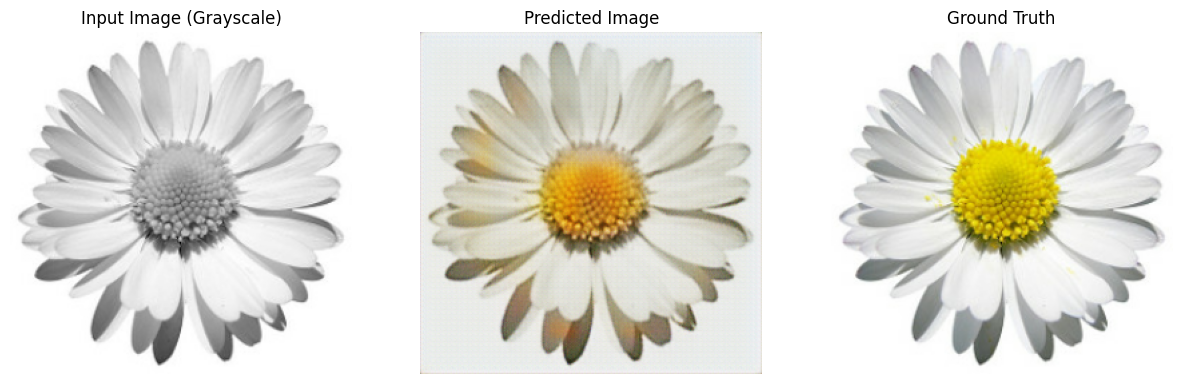


Checkpoint saved for epoch 5
Epoch 6/10
Epoch 6, Batch 100: Generator Loss: 19.0198, Discriminator Loss: 0.6429Epoch 7/10
Epoch 7, Batch 100: Generator Loss: 20.3479, Discriminator Loss: 0.6483Epoch 8/10
Epoch 8, Batch 100: Generator Loss: 17.8997, Discriminator Loss: 0.8924Epoch 9/10
Epoch 9, Batch 100: Generator Loss: 20.3631, Discriminator Loss: 0.5177Epoch 10/10
Epoch 10, Batch 100: Generator Loss: 19.4585, Discriminator Loss: 0.6781

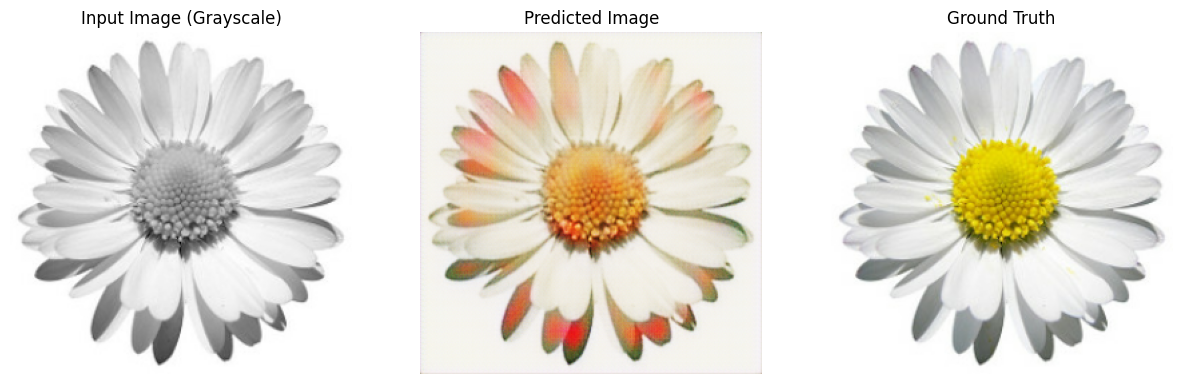


Checkpoint saved for epoch 10
Training complete.
Training initiated for 10 epochs.


In [ ]:
EPOCHS = 10
fit(processed_dataset, EPOCHS)
print(f"Training initiated for {EPOCHS} epochs.")